## Описание

 |         |                     |
 |---------|---------------------|
 |client_id|идентификатор клиента|
 |education	|уровень образования|
 |sex	|пол заёмщика|
 |age	|возраст заёмщика|
 |car|	флаг наличия автомобиля|
 |car_type|	флаг автомобиля-иномарки|
 |decline_app_cnt|	количество отказанных прошлых заявок|
 |good_work|	флаг наличия «хорошей» работы|
 |bki_request_cnt|	количество запросов в БКИ|
 |home_address|	категоризатор домашнего адреса|
 |work_address|	категоризатор рабочего адреса|
 |income|	доход заёмщика|
 |foreign_passport|	наличие загранпаспорта|
 |default|	наличие дефолта|

## Импорт

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")
import warnings
warnings.filterwarnings("ignore")

## Чтение данных, осмотр

In [2]:
data = pd.read_csv('./Project_4_data/train.csv')

#data.drop(columns='client_id',inplace=True)

In [3]:
data.head(3)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,M,62,Y,Y,0,0,1,1,2,18000,N,0
1,63161,SCH,F,59,N,N,0,0,3,2,3,19000,N,0
2,25887,SCH,M,25,Y,N,2,0,1,1,2,30000,Y,0


In [4]:
data.info()
print()
for col in data.columns:
    print("{:20} {}".format(col,type(data.loc[0,col])))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
client_id           73799 non-null int64
education           73492 non-null object
sex                 73799 non-null object
age                 73799 non-null int64
car                 73799 non-null object
car_type            73799 non-null object
decline_app_cnt     73799 non-null int64
good_work           73799 non-null int64
bki_request_cnt     73799 non-null int64
home_address        73799 non-null int64
work_address        73799 non-null int64
income              73799 non-null int64
foreign_passport    73799 non-null object
default             73799 non-null int64
dtypes: int64(9), object(5)
memory usage: 7.9+ MB

client_id            <class 'numpy.int64'>
education            <class 'str'>
sex                  <class 'str'>
age                  <class 'numpy.int64'>
car                  <class 'str'>
car_type             <class 'str'>
decline_app_cnt      <class 'numpy.

Проверим на дупликаты

In [5]:
data.duplicated().sum()

0

## Целевая переменная. Дисбаланс.
Посмотрим на соотношение классов в целевой переменной

In [6]:
data.default.value_counts(normalize=True)

0    0.873006
1    0.126994
Name: default, dtype: float64

Наблюдается значительный дисбаланс, учтем это при построении модели.

## Обработка пропусков.
Пропуски в явном виде присутсвуют только в `education`. Из протестированных способов заполнения, а именно: заполнение новой категорией "NAN_EDU", заполнение модой, заполнение категорией с распределением целевой переменной наиболее близким распределением на пропусках лучший (правда всего на 0,001) результат показало заполнение медианой. На ней и остановимся.

In [7]:
data.education.fillna(data.education.mode()[0],inplace=True)

# Изучение признаков

### Разделение на бинарные, категориальные и числовые

In [8]:
# num_uniq = data.drop(columns='default').nunique()
# bin_cols = data.drop(columns='default').columns[num_uniq==2]
# cat_cols = data.drop(columns='default').columns[(num_uniq>2) & (num_uniq<7)] 
# num_cols = data.drop(columns='default').columns[num_uniq>6]

num_uniq = data.nunique()
bin_cols = data.columns[num_uniq==2]
cat_cols = data.columns[(num_uniq>2) & (num_uniq<7)] 
num_cols = data.columns[num_uniq>6]

## Численные признаки

In [9]:
num_cols

Index(['client_id', 'age', 'decline_app_cnt', 'bki_request_cnt', 'income'], dtype='object')

### client_id
Согласно описанию - идентификатор клиента

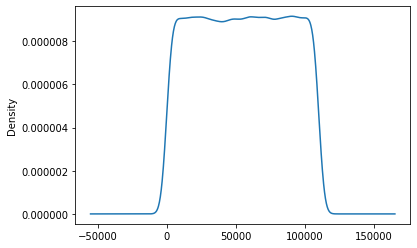

In [10]:
data.client_id.plot.density()

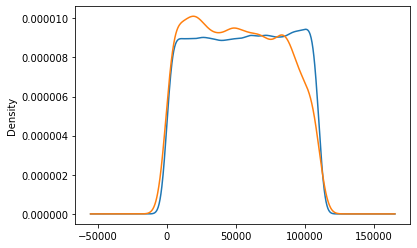

In [11]:
neg_mask = data.default==0
pos_mask = data.default==1

data[neg_mask].client_id.plot.density()
data[pos_mask].client_id.plot.density()

Как видим .....................................

### age
Согласно описанию - возраст заёмщика

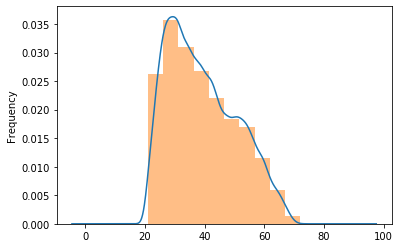

In [12]:
data.age.plot.density(); data.age.plot.hist(density=True,alpha = 0.5)

логарифмируем

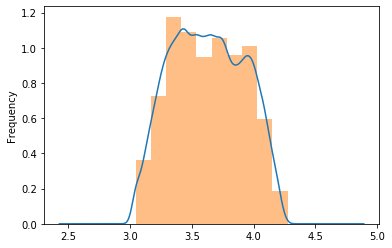

In [13]:
np.log(data.age).plot.density(); np.log(data.age).plot.hist(density=True,alpha = 0.5)

различие распределений

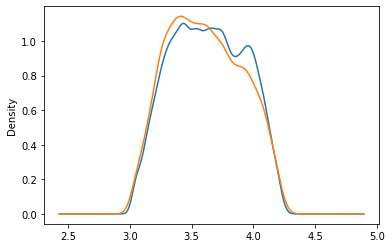

In [14]:
np.log(data[neg_mask].age).plot.density()
np.log(data[pos_mask].age).plot.density()

### decline_app_cnt
Согласно описанию - количество отказанных прошлых заявок

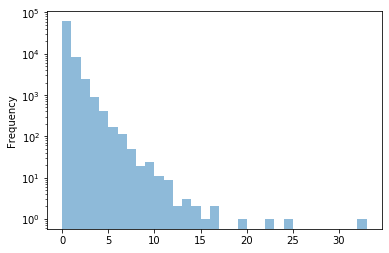

In [15]:
n_bins = data.decline_app_cnt.max() - data.decline_app_cnt.min()

plt.yscale('log')
(data.decline_app_cnt).plot.hist(bins = n_bins, density=False,alpha = 0.5)

In [16]:
# data.decline_app_cnt.value_counts()

Распределение сильно напоминает распределение Пуассона (что не удивительно - ведь `decline_app_cnt` является именно счетчиком событий)
Как видим начиная со значеиий в области 10 количество наблюдений становится коайне мало. Наверное стоит попробовать отбросить  

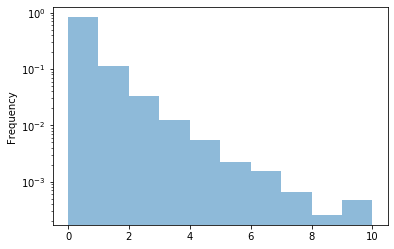

In [17]:
plt.yscale('log')
data.decline_app_cnt[data.decline_app_cnt<11].plot.hist(bins = 10, density=True,alpha = 0.5)
# data.decline_app_cnt[data.decline_app_cnt<11].plot.density()

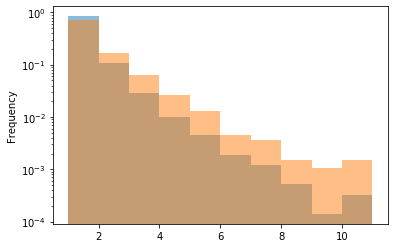

In [18]:
plt.yscale('log')
(data[neg_mask].decline_app_cnt[data[neg_mask].decline_app_cnt<11]+1).plot.hist(bins = 10, density=True,alpha = 0.5)
(data[pos_mask].decline_app_cnt[data[pos_mask].decline_app_cnt<11]+1).plot.hist(bins = 10, density=True,alpha = 0.5)


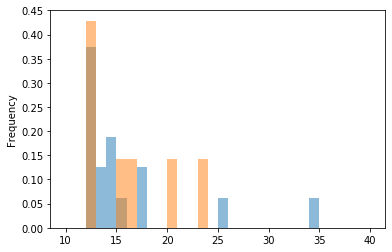

In [19]:
# plt.yscale('log')
m = data.decline_app_cnt.max()
(data[neg_mask].decline_app_cnt[data[neg_mask].decline_app_cnt>=11]+1).plot.hist(bins = 30, 
                                                                               density=True,alpha = 0.5,range = (10,40))
(data[pos_mask].decline_app_cnt[data[pos_mask].decline_app_cnt>=11]+1).plot.hist(bins = 30,
                                                                               density=True,alpha = 0.5,range = (10,40))

### bki_request_cnt

Согласно описанию - количество запросов в БКИ.

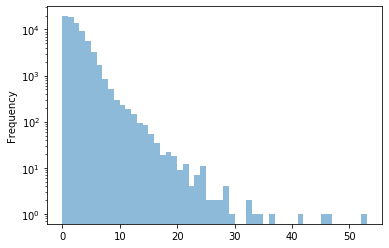

In [20]:
n_bins = data.bki_request_cnt.max() - data.bki_request_cnt.min()

plt.yscale('log')
data.bki_request_cnt.plot.hist(bins = n_bins, density=False,alpha = 0.5)

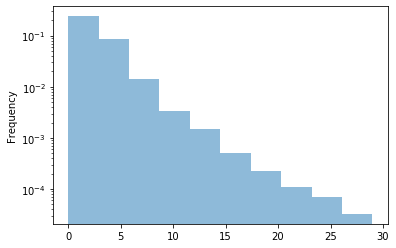

In [21]:
plt.yscale('log')
data.bki_request_cnt[data.bki_request_cnt<30].plot.hist(bins = 10, density=True,alpha = 0.5)

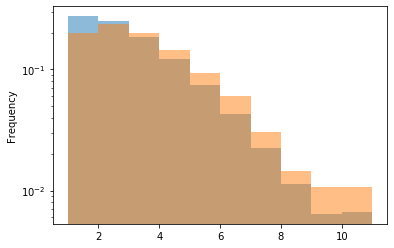

In [22]:
plt.yscale('log')
(data[neg_mask].bki_request_cnt[data[neg_mask].bki_request_cnt<11]+1).plot.hist(bins = 10, density=True,alpha = 0.5)
(data[pos_mask].bki_request_cnt[data[pos_mask].bki_request_cnt<11]+1).plot.hist(bins = 10, density=True,alpha = 0.5)

### income
Согласно описанию - доход заёмщика

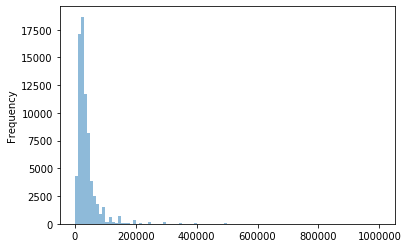

In [23]:
data.income.plot.hist(bins = 100, density=False,alpha = 0.5)

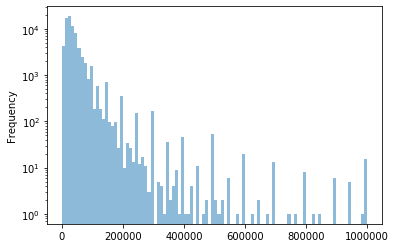

In [24]:
plt.yscale('log')
data.income.plot.hist(bins = 100, density=False,alpha = 0.5)

# ИДЕИ, ПРОРАБОТКА

## Разделение данных по ID

In [94]:
# data.client_id

In [95]:
# treshold = 80000

# data_stat = data[data.client_id<treshold]
# data_nonstat = data[data.client_id>=treshold]

In [32]:
%%time

model = LogisticRegression(class_weight = 'balanced')
cv = StratifiedKFold(n_splits=5,random_state=42)

reports = {}
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, train_sizes=np.linspace(.1, 1.0, 10), cv=cv, scoring = 'roc_auc')
reports = {'train_sizes':train_sizes, 'train_scores':train_scores, 'test_scores':test_scores}

# with open('reports', 'wb') as file_to_save: pickle.dump(reports, file_to_save)
# with open ('reports', 'rb') as file_to_save: reports = pickle.load(file_to_save)

# Wall time: 20min 20s

Wall time: 12.5 s


In [38]:
train_scores.mean(axis=1)

array([0.67829476, 0.67642872, 0.67088944, 0.67007167, 0.67120383,
       0.67234089, 0.67459523, 0.67353021, 0.67383807, 0.67290951])

In [39]:
test_scores.mean(axis=1)

array([0.66669923, 0.66877136, 0.67002371, 0.67046897, 0.67094581,
       0.67123781, 0.67159456, 0.6717162 , 0.67182145, 0.67185333])

# ========================BASELINE=========================


# Обработка данных

In [10]:
# чтение для baseline-а
data = pd.read_csv('./Project_4_data/train.csv')

# data = data[(data.client_id>10000) & (data.client_id<20000)] # treshold
# data = data[(data.client_id<treshold)] # treshold


data.education.fillna(data.education.mode()[0],inplace=True)

In [11]:
# bin_cols.drop('default')

## Числовые признаки

### Логарифмированние числовых признаков

In [12]:
for col in num_cols:
    data[col] = np.log(data[col]+1)

### Нормализация/

In [13]:
scaler = MinMaxScaler()
# scaler = StandardScaler()

data[num_cols] = scaler.fit_transform(data[num_cols].values)

## Бинарные признаки

In [14]:
label_encoder = LabelEncoder()
for col in bin_cols.drop('default'):
    data[col] = label_encoder.fit_transform(data[col])
    
# data.head(7)

## Категориальные признаки

In [15]:
# X_cat = OneHotEncoder(sparse = False).fit_transform(data[cat_cols].values)
data = pd.get_dummies(data,columns=cat_cols)
data.columns

Index(['client_id', 'sex', 'age', 'car', 'car_type', 'decline_app_cnt',
       'good_work', 'bki_request_cnt', 'income', 'foreign_passport', 'default',
       'education_ACD', 'education_GRD', 'education_PGR', 'education_SCH',
       'education_UGR', 'home_address_1', 'home_address_2', 'home_address_3',
       'work_address_1', 'work_address_2', 'work_address_3'],
      dtype='object')

## Объединяем в матрицу, отделяем целевую переменную

In [16]:
# X = np.hstack([data[num_cols].values, data[bin_cols].values, X_cat])
X = data.drop(columns='default')#.values
y = data['default'].values

In [18]:
X.columns

Index(['client_id', 'sex', 'age', 'car', 'car_type', 'decline_app_cnt',
       'good_work', 'bki_request_cnt', 'income', 'foreign_passport',
       'education_ACD', 'education_GRD', 'education_PGR', 'education_SCH',
       'education_UGR', 'home_address_1', 'home_address_2', 'home_address_3',
       'work_address_1', 'work_address_2', 'work_address_3'],
      dtype='object')

# Разбиение на train и test

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20) # , random_state=42

# Модель

In [20]:
cl_wgt = {0:1,1:1}

model = LogisticRegression(class_weight = 'balanced')
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

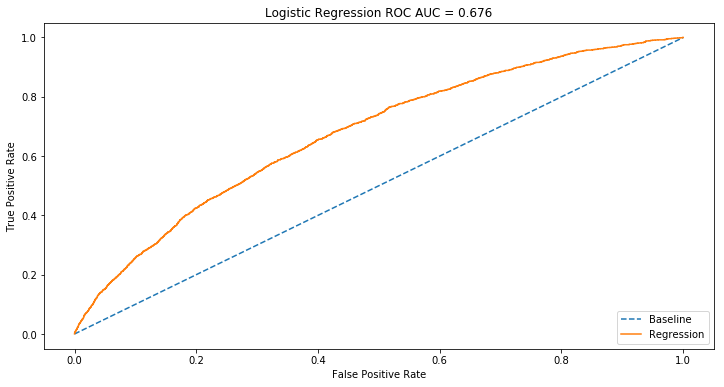

In [21]:
probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure(figsize=(12,6))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# Подбор макропараметрв
solver {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’  
    class_weight dict or ‘balanced’, default=None  
    intercept_scaling float, default=1  
    C  float, default=1.0  
tol   float, default=1e-4  


In [24]:
%%time
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

# Добавим типы регуляризации
penalty = ['l1', 'l2']
# Зададим ограничения для параметра регуляризации
C = np.logspace(-3, 3, 7)
#
class_weight = [None, 'balanced'] # [{0:0, 1:x} for x in range(1,12,3)]
#
intercept_scaling = [1,10,30]
#
solver = ['newton-cg','lbfgs', 'liblinear', 'sag', 'saga']


# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty, class_weight=class_weight, 
                       solver = solver, intercept_scaling=intercept_scaling)

model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, scoring='roc_auc', cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
print('Besr score', clf.best_score_)

Лучшее Penalty: l1
Лучшее C: 1.0
Besr score 0.670512911298753
Wall time: 58min 9s


In [113]:
best_model.best_estimator_.get_params()['class_weight']

'balanced'

In [27]:
best_model.best_estimator_.get_params()['intercept_scaling']

25

In [23]:
[{0:0, 1:x} for x in range(1,12,3)] + [None, 'balanced']

[{0: 0, 1: 1}, {0: 0, 1: 4}, {0: 0, 1: 7}, {0: 0, 1: 10}, None, 'balanced']

In [25]:
clf.best_score_

0.670512911298753

In [26]:
clf.cv_results_['mean_test_score']

array([0.56494647, 0.63645117, 0.5       , 0.63888616, 0.5       ,
       0.63881909, 0.59911097, 0.64742298, 0.59916137, 0.64742746,
       0.59912728, 0.64742763, 0.65892039, 0.66348249, 0.65842878,
       0.66280525, 0.65834679, 0.6627914 , 0.66581304, 0.66692044,
       0.66542154, 0.66716479, 0.66525919, 0.66716511, 0.67014389,
       0.67013181, 0.67024329, 0.6701007 , 0.67022697, 0.66999301,
       0.67038582, 0.67043361, 0.67050116, 0.6704582 , 0.67050323,
       0.67045776, 0.67042995, 0.67041883, 0.67043677, 0.67041955,
       0.67044022, 0.67046736, 0.67050758, 0.67050717, 0.67051291,
       0.67050833, 0.67051245, 0.67050823, 0.67041638, 0.67041476,
       0.6704031 , 0.67043171, 0.67042991, 0.67049787, 0.67050381,
       0.67050522, 0.6705046 , 0.67050537, 0.67050409, 0.67050535,
       0.67039994, 0.67041237, 0.67044325, 0.67042356, 0.67045034,
       0.6703232 , 0.67050292, 0.67050312, 0.67050361, 0.67050335,
       0.67050344, 0.67050336, 0.67040896, 0.67041276, 0.67042

# =========================РАЗНОЕ=============================
# =======================РАЗРАБОТКА==========================

In [107]:
[{0:0, 1:x} for x in range(1,12,3)] + [None, 'balanced']

[{0: 0, 1: 1}, {0: 0, 1: 4}, {0: 0, 1: 7}, {0: 0, 1: 10}, None, 'balanced']

In [68]:
[x**2 for x in range(1,6,2)]

[1, 9, 25]

In [ ]:
list(C)

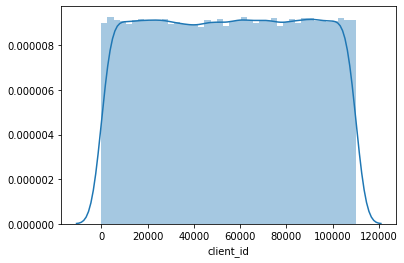

In [6]:
sns.distplot(data.client_id)

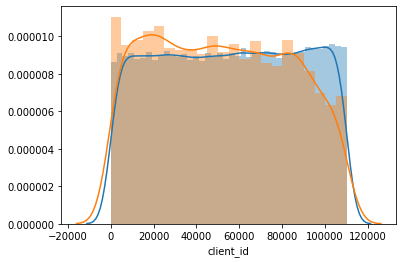

In [31]:
sns.distplot(data.loc[data.default==0].client_id)
sns.distplot(data.loc[data.default==1].client_id)

In [7]:
data.columns

Index(['client_id', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'bki_request_cnt', 'home_address',
       'work_address', 'income', 'foreign_passport', 'default'],
      dtype='object')

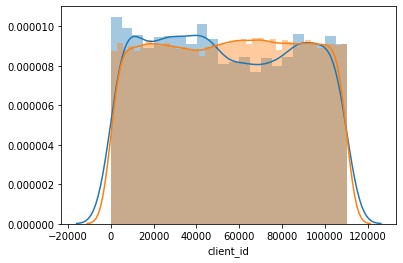

In [8]:
sns.distplot(data.loc[data.foreign_passport=='Y'].client_id)
sns.distplot(data.loc[data.foreign_passport=='N'].client_id)

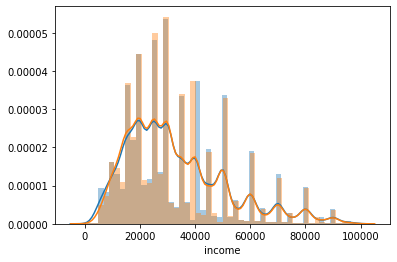

In [9]:
# plt.xscale('log')
sns.distplot(data.income[data.client_id<65000][data.income<100000])
sns.distplot(data.income[data.client_id>65000][data.income<100000])

In [11]:
# разделим на типы признаков
num_uniq = data.drop(columns='default').nunique()

bin_cols = data.drop(columns='default').columns[num_uniq==2]
cat_cols = data.drop(columns='default').columns[(num_uniq>2) & (num_uniq<7)] 
num_cols = data.drop(columns='default').columns[num_uniq>6]

In [12]:
bin_cols

Index(['sex', 'car', 'car_type', 'good_work', 'foreign_passport'], dtype='object')

In [13]:
num_cols

Index(['client_id', 'age', 'decline_app_cnt', 'bki_request_cnt', 'income'], dtype='object')

In [28]:
data.foreign_passport.unique()

array(['N', 'Y'], dtype=object)

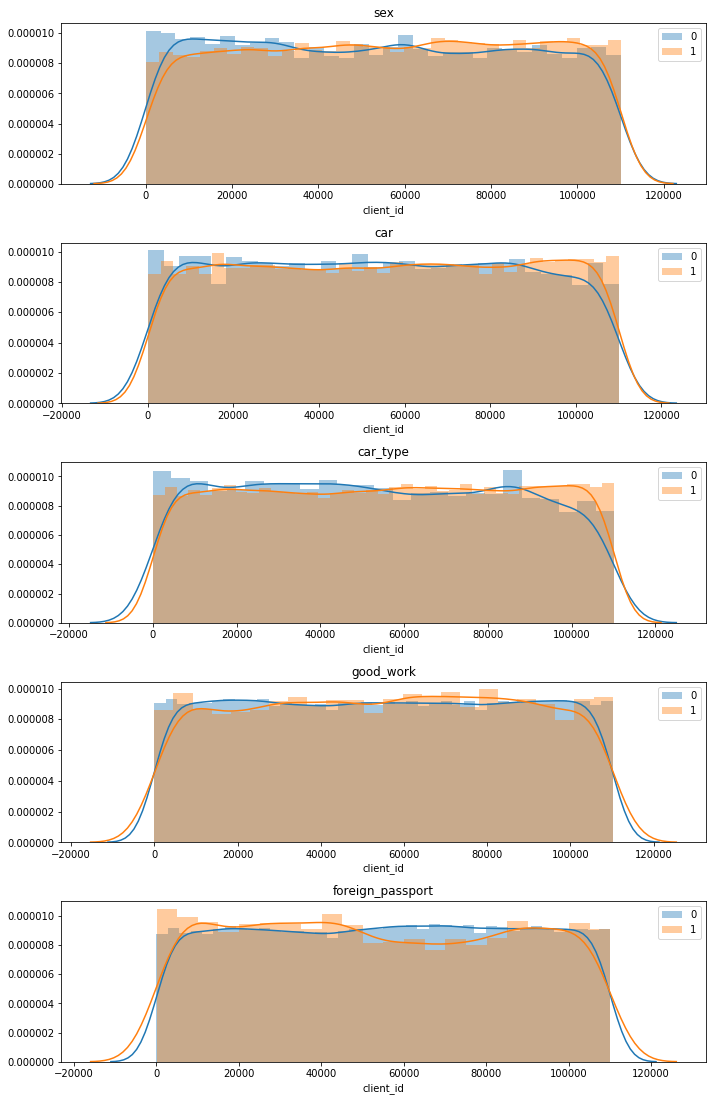

In [26]:
features = bin_cols
column_num = 1
row_num = len(features)//column_num+1

plt.figure(figsize=(10,3*row_num))
for i,column in enumerate(features):
    categories = data[column].unique()
    plt.subplot(row_num,column_num,i+1)
    sns.distplot(data.loc[data[column]==categories[0]].client_id,label=0)
    sns.distplot(data.loc[data[column]==categories[1]].client_id,label=1)
    plt.legend() 
    plt.title(column)
    plt.tight_layout()
plt.show()




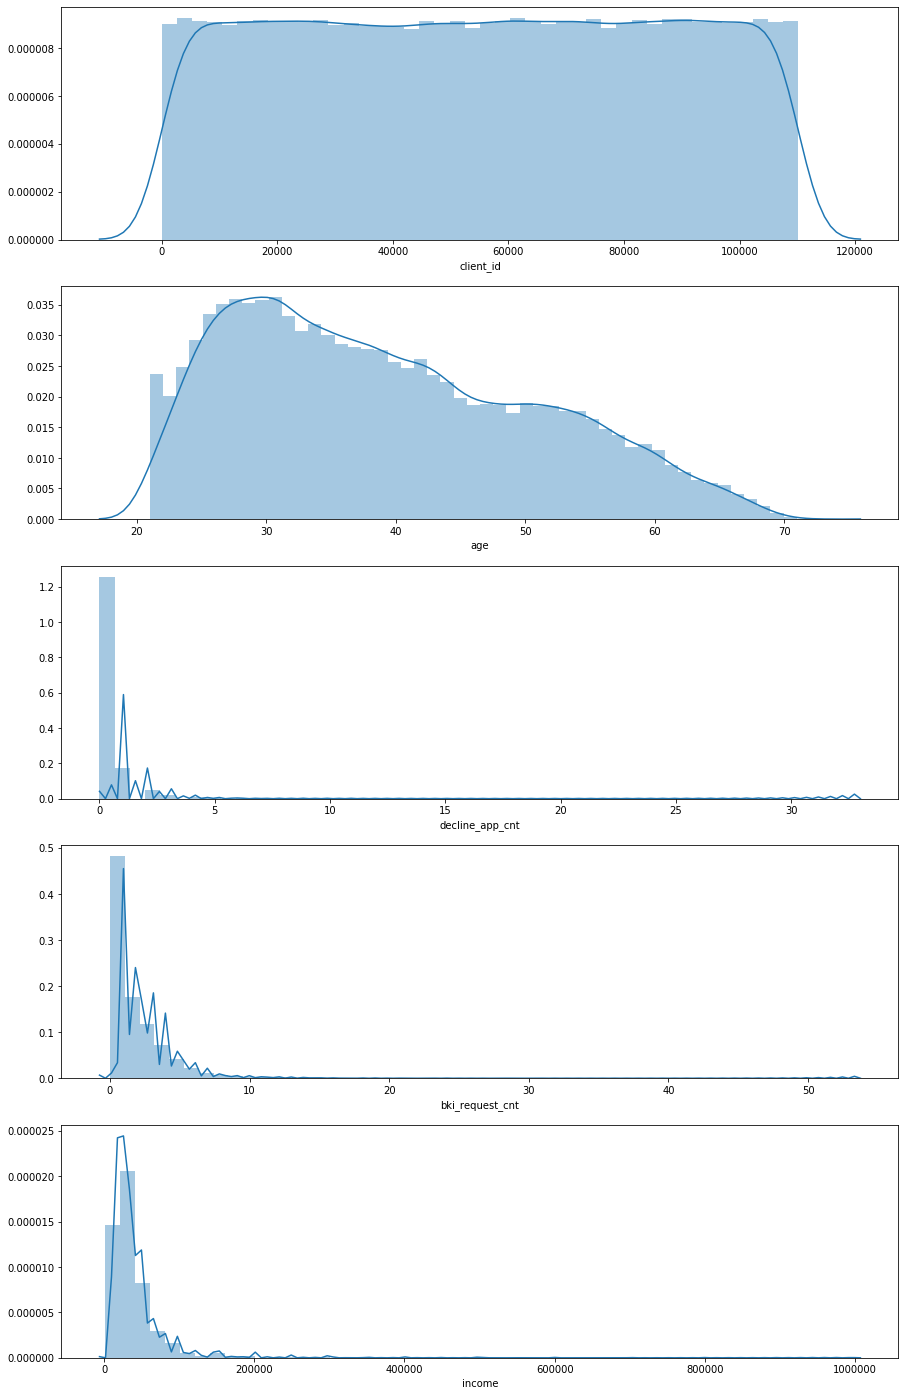

In [16]:
features = num_cols
column_num = 1
row_num = len(features)//column_num+1

plt.figure(figsize=(15,5*row_num))
for i,column in enumerate(features):
    plt.subplot(row_num,column_num,i+1)
    sns.distplot(data[column])
plt.show()

In [96]:
data.income.value_counts().sort_index()

-4.926396     5
-4.789920     1
-4.345726     2
-4.166443     1
-3.933633     1
             ..
 4.899453     4
 4.958566     1
 4.971537     2
 4.972970     3
 4.972971    10
Name: income, Length: 966, dtype: int64

## ПОДВАЛ

In [44]:
default_by_id = pd.Series(data.default.tolist(),index = data.client_id.tolist()) 

In [106]:
aaa = (data.decline_app_cnt>0) & (data.bki_request_cnt==0)
aaa.sum()

2588

In [111]:
data.default[(data.bki_request_cnt==0)].value_counts(normalize=True)

0    0.90501
1    0.09499
Name: default, dtype: float64

In [ ]:
MinMaxScaler()

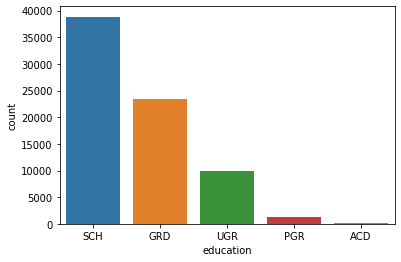

In [148]:
sns.countplot(x="education", data=data)

In [ ]:
# data.education.fillna('NAN_EDU', inplace=True)

# nan_dflt_prop = data.default[data.education.isna()].value_counts(normalize=True)[0]

# dflt_prop = data.groupby('education').apply(lambda x: x.default.value_counts(normalize=True)[0])
# to_fill = abs(dflt_prop - nan_dflt_prop).idxmin()

#  data.education.fillna(to_fill,inplace=True)

In [10]:
# ДЛЯ ЗАПОЛНЕНИЯ ПРОПУСКОВ В EDUCATION
'''regr = RandomForestRegressor(n_estimators=100, random_state = RANDOM_SEED)

regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)''';

In [11]:
GridSearchCV

NameError: name 'GridSearchCV' is not defined

In [55]:
data.default.unique()

array([0, 1], dtype=int64)

### ===================================================================================

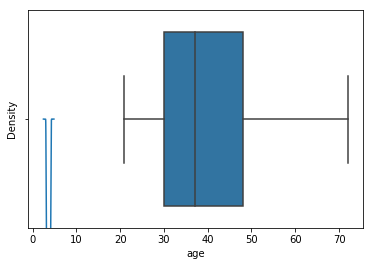

In [29]:
np.log(data.age+1).plot.density()
sns.boxplot(x=data.age)

In [122]:
def num_visualisation(row):
#     min_diff = pd.Series(row.unique()).sort_values().diff().min()
#     bins = (row.max()-row.min()) / min_diff
#     bins_range = row.min()-min_diff/2 ,row.max()+min_diff/2 

    fig = plt.figure()
    
    ax1 = fig.add_axes([0, 0.35, 1, 1])
    sns.distplot(row)

    ax2 = fig.add_axes([0, 0, 1, 0.2]) 
    ax1.get_shared_x_axes().join(ax1, ax2)
    sns.boxplot(x=row)
    
    plt.tight_layout()

In [125]:
num_cols

Index(['client_id', 'age', 'decline_app_cnt', 'bki_request_cnt', 'income'], dtype='object')

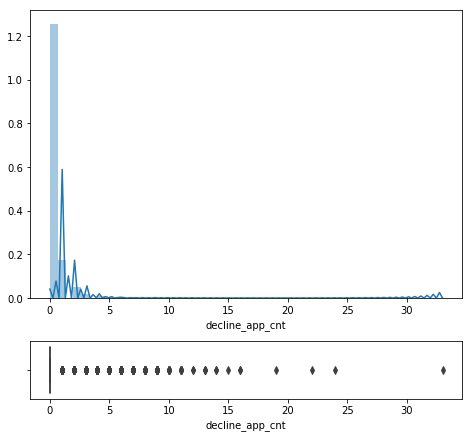

In [127]:
num_visualisation(data.decline_app_cnt)

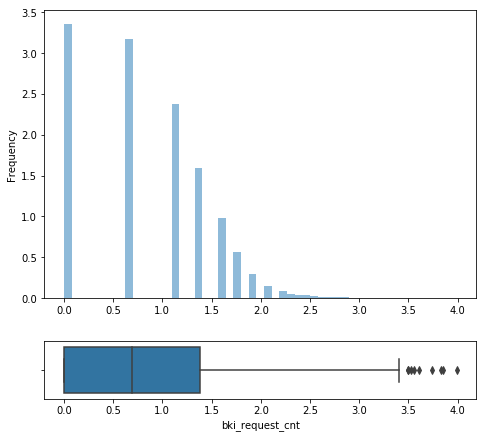

In [130]:
row = np.log(data.bki_request_cnt+1)

min_diff = pd.Series(row.unique()).sort_values().diff().min()
bins = (row.max()-row.min()) / min_diff
bins_range = row.min()-min_diff/2 ,row.max()+min_diff/2 

fig = plt.figure()
ax1 = fig.add_axes([0, 0.35, 1, 1])
# sns.distplot(row)
row.plot.hist(bins=51,density=True,alpha = 0.5)
ax2 = fig.add_axes([0, 0, 1, 0.2])
ax1.get_shared_x_axes().join(ax1, ax2) 
sns.boxplot(x=row)
plt.tight_layout()


In [ ]:
axes_main.twinx

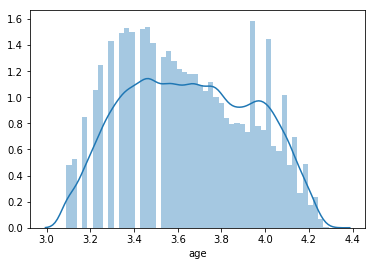

In [102]:
sns.distplot(row)

(20.5, 72.5)

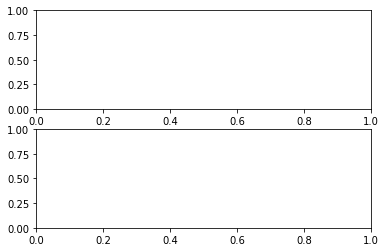

In [114]:
# plt.subplot(1, 2, 1)
plt.subplot(2, 1, 1)
plt.subplot(2, 1, 2)
# plt.subplot(1, 2, 2)